<h3>Import libraries, load data and define functions</h3>

Import some useful libraries and set the style of the plots

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
print('pandas version: ',pd.__version__)
print('numpy version: ',np.__version__)
print('matplotlib version: ',np.__version__)
print('seaborn version: ',sns.__version__)
#set style of sns and display in workbook.
sns.set_style(style='whitegrid')
%matplotlib inline

pandas version:  0.20.1
numpy version:  1.12.1
matplotlib version:  1.12.1
seaborn version:  0.7.1


load training and test data.

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
#combine used to apply updates to both training and test dataset simultaneously
combine = [train, test]

Define functions to calculate percentage values of passengers survived and to group passengers into age groups.

In [3]:
#define function to determine the percentage of survivors by certain feature
def per_survived(DataFrame,feature,feature_value):
    """
    Take in the feature to analyse and the value of that feature and returns the percentage 
    of no-shows. Intended to use as part of lambda function to update DataFrame.
    
    Parameters
    ----------
    df : the DataFrame to analyse
    feature : str
        feature of the DataFrame to analyse
    feature_value : scalar
        the feature_value to analyse
        
    """
    measure = DataFrame[(DataFrame['Survived']==1) & (DataFrame[feature]==feature_value)]['Survived'].count()
    total = DataFrame[DataFrame[feature]==feature_value][feature].count()
    return round((measure / total) * 100,2)

In [4]:
def set_age_group(x):
    """Set an age range
    """
    if x <=3:
        return 'infant',0
    elif x <=10:
        return 'child',1
    elif x <=18:
        return 'adolescent',2
    elif x <= 25:
        return 'Young Adult',3
    elif x <= 45:
        return 'Adult',4
    elif x <= 75:
        return 'Middle Aged',5
    else:
        return 'Elderly',6

In [5]:
def set_fare_bands(x,df,column_in,column_return):
    """Takes in the fare,the DataFrame of FareBands,the column name of the FareBands as an interval
    and returns the FareBand as a scalar value.
    """ 
    for i in range (len(df)):
        if x in df[column_in].loc[i]:
            return df[column_return].loc[i]

<h3>Exploratory Data analysis.</h3>

In [6]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [8]:
# Grab info about DataFrame
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


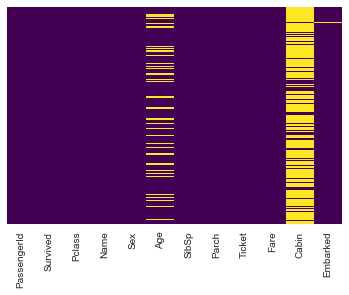

In [9]:
# Check for null values
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')
print(train.isnull().sum())

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


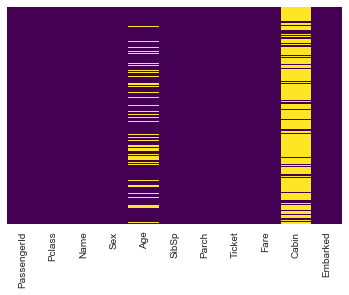

In [10]:
# Check for null values
sns.heatmap(test.isnull(),yticklabels=False,cbar=False,cmap='viridis')
print(test.isnull().sum())

From an initial look at the data, survived is the label. Some feature engineering will be required on the training set, with passenger ID and ticket likely to not be useful, as passenger ID appears to sequential. Name may contain some information with some manipulation, as will categorical features such as sex and embarked.<br/>
Age and Embarked have some missing values, but should be able to impute this data. Cabin only has 204 values (and may provide similar info to class) will be removed.<br/>
For the test set; Cabin has similar issues to the training set, and Age and Fare also has a number of missing values, which will need to be handled later.

<h3>Exploratory Data Analysis</h3>

Percentage survived = 38.4%


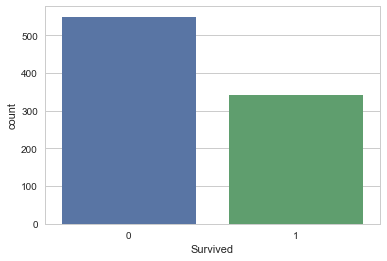

In [11]:
sns.countplot(x='Survived',data=train)
print('Percentage survived = {}%'.format(round((train[train['Survived']==1]['Survived'].sum()/len(train))*100,1)))

The survived label is slightly imbalanced with less passengers surviving.

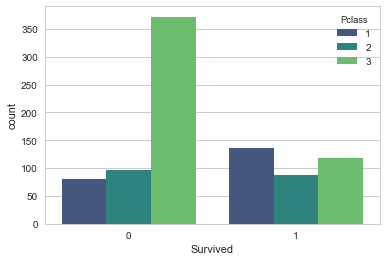

In [12]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Pclass',data=train,palette='viridis')

It also looks less likely that you would survive if you were in 3rd class.<br/>
Now lets take a look as age groups. Firstly assign an age group to each passenger.

In [13]:
combine = [train,test]
for dataset in combine:
    dataset['Age_Group'] = dataset['Age'].apply(lambda x: set_age_group(x))

Then create a new Data Frame for plotting this information.

In [14]:
# Create a DataFrame with value counts of patients ages
train_ages = pd.DataFrame(train['Age_Group'].value_counts())

In [15]:
# Clean up DataFrame
train_ages.reset_index(inplace=True)
train_ages['Description'],train_ages['Rank'] = zip(*train_ages['index'])
train_ages.set_index('Rank',inplace=True)
train_ages.sort_index(inplace=True)
train_ages.rename(columns={'Age_Range':'Count'},inplace=True)

In [16]:
# Add a column of the percentage survived
train_ages['Survival Percent'] = train_ages['index'].apply(lambda x: per_survived(train,'Age_Group',x))

In [17]:
#Drop extra information from train and test dataframe to leave just age group
combine = [train,test]
for dataset in combine:
    dataset['Age_Group'] = dataset['Age_Group'].apply(lambda x : x[1])

In [18]:
train_ages

,index,Age_Group,Description,Survival Percent
Rank,,,,
0,"(infant, 0)",30,infant,66.67
1,"(child, 1)",34,child,52.94
2,"(adolescent, 2)",75,adolescent,42.67
3,"(Young Adult, 3)",162,Young Adult,33.33
4,"(Adult, 4)",310,Adult,41.29
5,"(Middle Aged, 5)",102,Middle Aged,36.27
6,"(Elderly, 6)",178,Elderly,29.78


Now we can plot the age group against the percentage of that age group that survived.

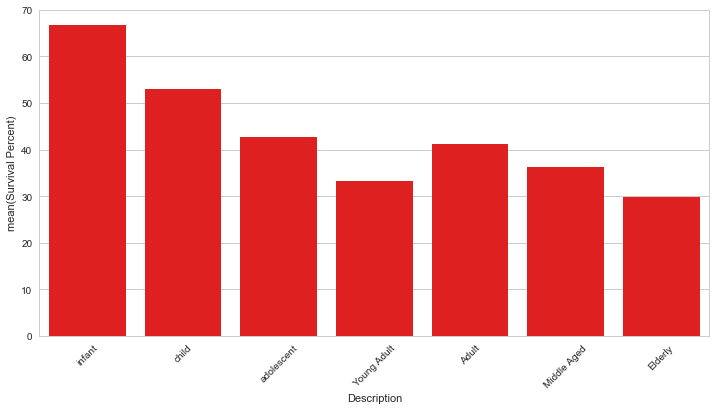

In [19]:
plt.figure(figsize=(12,6))
plt.xticks(rotation=45)
sns.barplot(x='Description',y='Survival Percent',data=train_ages,color='red')

The general trend of this graph is as the age group increased the smaller percentage of passengers survived, with a dip in the trend among young adults. Maybe women and children were prioritised in the evacuation, lets look at the numbers of passengers survived by sex.

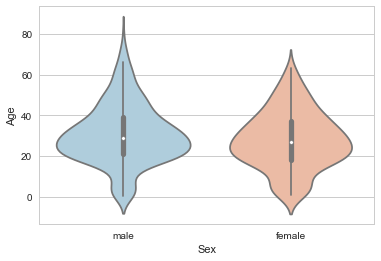

In [20]:
sns.violinplot(x='Sex',y='Age',data=train,palette='RdBu_r')

Both distributions appear similar, with a large number of passengers travelling in their early 20s, there appears to be more girls travelling than boys, with the males having a longer tail at the older end of the distribution.

female survived: 74.2%
male survived: 18.89%


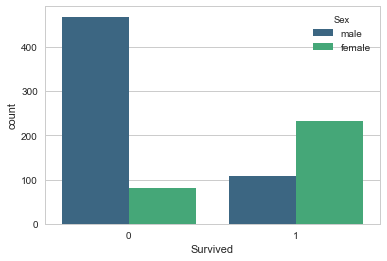

In [21]:
sns.countplot(x='Survived',hue='Sex',data=train,palette='viridis')
print('female survived: {}%' .format(per_survived(train,'Sex','female')))
print('male survived: {}%' .format(per_survived(train,'Sex','male')))

This shows a far larger number of males did not survive compared to female passengers.

In [22]:
male_survived = train[(train['Survived']==1) & (train['Sex']=='male')]['Survived'].sum()
male_perished = len(train) - male_survived
female_survived = train[(train['Survived']==1) & (train['Sex']=='female')]['Survived'].sum()
female_perished = len(train) - female_survived

In [23]:
obs = np.array([[male_survived,male_perished], [female_survived,female_perished]])
chi2, p, dof, expected = stats.chi2_contingency(obs)
print ('p value: ',p)

p value:  1.37361170265e-13


Which is statistically significant.<br/>
Splitting the violin plot into survived and not survived also highlights some important information. Both plots again show the large bulge around the early 20's, but then for passengers under this age, and especially for boys, in the not survived plot the number of passengers drops off quite quickly whereas in the survived plot the shape of the distribution is different.

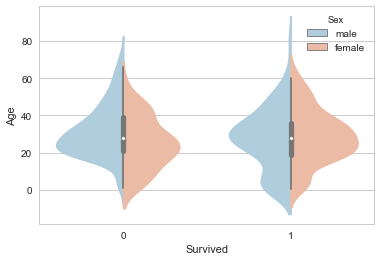

In [24]:
sns.violinplot(x='Survived',y='Age',hue='Sex',split=True,data=train,palette='RdBu_r')

See if people travelling alone were more or less likely to survive.<br/>Use a quick lambda function to create a feature showing whether that person was travelling alone, or had spouses, siblings etc... This isn't perfect as it doesn't cover friends travelling together, mistresses etc... but gives an insights into families.

In [25]:
combine = [train, test]
for dataset in combine:
    dataset['Alone']= dataset.apply(lambda x: 1 if x['SibSp']==0 & x['Parch']==0 else 0,axis=1)

In [26]:
combine = [train, test]
for dataset in combine:
    dataset['Relatives'] = dataset.apply(lambda x: x['SibSp']+x['Parch'],axis=1)

In [27]:
train.head(20)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_Group,Alone,Relatives
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,3,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,4,0,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,4,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,4,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,4,1,0
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,6,1,0
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,5,1,0
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,0,0,4
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,4,1,2
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,2,0,1


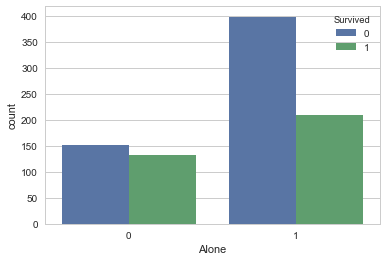

In [28]:
sns.countplot(x='Alone',hue='Survived',data=train)

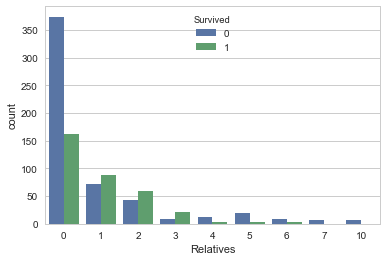

In [29]:
sns.countplot(x='Relatives',hue='Survived',data=train)

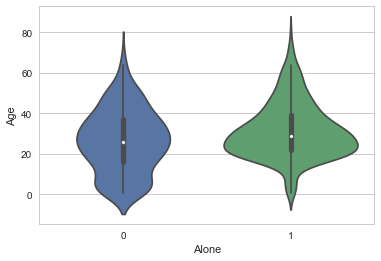

In [30]:
sns.violinplot(x='Alone',y='Age',data=train)

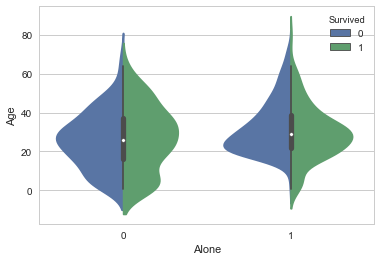

In [31]:
sns.violinplot(x='Alone',y='Age',hue='Survived',split=True,data=train)

Now lets explore where the passengers embarked from.

In [32]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Southampton survived: 33.7%
Cherbourg survived: 55.36%
Queenstown survived: 38.96%


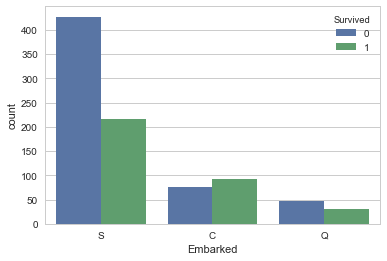

In [33]:
sns.countplot(x='Embarked',hue='Survived',data=train)
print('Southampton survived: {}%' .format(per_survived(train,'Embarked','S')))
print('Cherbourg survived: {}%' .format(per_survived(train,'Embarked','C')))
print('Queenstown survived: {}%' .format(per_survived(train,'Embarked','Q')))

The highest number of passengers embarked at Southampton, however this also had the lowest survival percentage.

<h3>Feature Engineering</h3>

Some feature engineering has already been performed in the previous section. Here it will be completed in preparation for modelling.

Neat way to update both training and test sets.

In [34]:
print("Before", train.shape, test.shape, combine[0].shape, combine[1].shape)

train = train.drop(['PassengerId','Ticket', 'Cabin'], axis=1)
#keep PassengerId for submission
test = test.drop(['PassengerId','Ticket', 'Cabin'], axis=1)
combine = [train, test]

"After", train.shape, test.shape, combine[0].shape, combine[1].shape

Before (891, 15) (418, 14) (891, 15) (418, 14)


('After', (891, 12), (418, 11), (891, 12), (418, 11))

In [35]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Age_Group,Alone,Relatives
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,3,0,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,4,0,1
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,4,1,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,4,0,1
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,4,1,0


In [36]:
test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Age_Group,Alone,Relatives
0,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,Q,4,1,0
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,S,5,0,1
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,Q,5,1,0
3,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,S,4,1,0
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,S,3,0,2


I will keep the age column for the time being as it will come in useful later, however it will be removed before running any models. The reason for removing age and replacing with age groups is Age is potentially too granular and could lead to overfitting.<br/>
For the same reasoning Fare can be engineered in this fashion too. However by looking at the histogram below, if fare was split into a handful of bands the vast majority would be in the first bin as the fares are very skewed.

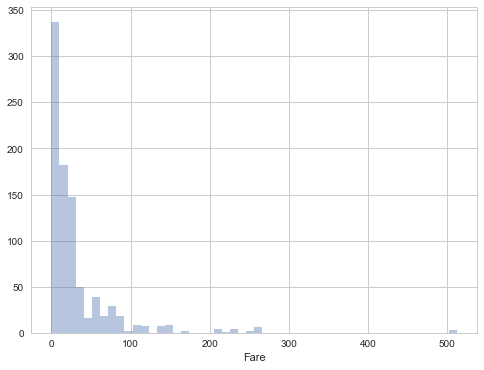

In [37]:
plt.figure(figsize=(8,6))
sns.distplot(train['Fare'],bins=50,kde=False)

Fortunately Pandas has a built in function called qcut to even this out. Firstly though we need to handle to NaN in the test set

In [38]:
imput = test.sort_values('Fare')['Fare'].median()

test['Fare'].fillna(value=imput,inplace=True)
test['Fare'].isnull().sum()

0

Then use qcut to split the fares into separate bands.

In [39]:
combine = [train,test]
for dataset in combine:
    dataset['Fare'] = dataset['Fare'].astype(int)
train['FareBand'] = pd.qcut(train['Fare'], 6)

It is then possible to use this data to change the Fare to a categorical column. First create a new Data Frame with the Fareband in.

In [40]:
df_Fare_bands = train[['FareBand', 'Survived']].groupby(['FareBand'], 
                as_index=False).mean().sort_values(by='FareBand', ascending=True)
df_Fare_bands.reset_index(inplace=True)
df_Fare_bands.rename(columns={'index':'Band','FareBand':'Interval'},inplace=True)
df_Fare_bands

,Band,Interval,Survived
0,0,"(-0.001, 7.0]",0.215768
1,1,"(7.0, 8.0]",0.142857
2,2,"(8.0, 14.0]",0.356164
3,3,"(14.0, 26.0]",0.484848
4,4,"(26.0, 52.0]",0.382114
5,5,"(52.0, 512.0]",0.691781


Then this information can be passed to the set_fare_bands function. The function uses the intervals in the fare bands DataFrame and if the fare is within this interval the corresponding Band is assigned.

In [41]:
combine = [train,test]
for dataset in combine:
    dataset['Fare'] = dataset['Fare'].apply(lambda x: set_fare_bands(x,df_Fare_bands,'Interval','Band'))
train.drop('FareBand',axis=1,inplace=True)

In [42]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Age_Group,Alone,Relatives
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,0,S,3,0,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,5,C,4,0,1
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,0,S,4,1,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,5,S,4,0,1
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,1,S,4,1,0


Now change some of the qualitative columns to quantitative values, starting with male and female to integer values.

In [43]:
combine = [train, test]
for dataset in combine:
    dataset['Sex'].replace(['female','male'],[0,1],inplace=True)
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Age_Group,Alone,Relatives
0,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,0,S,3,0,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,5,C,4,0,1
2,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,0,S,4,1,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,5,S,4,0,1
4,0,3,"Allen, Mr. William Henry",1,35.0,0,0,1,S,4,1,0


For embarked we first need to impute null values, as there's only two missing values the modal value can be used.

In [44]:
#impute missing values with most common.
combine = [train, test]
for dataset in combine:
    dataset['Embarked'].fillna(value='S',inplace=True)
train['Embarked'].isnull().sum()

0

The built in pandas function of get dummies can then be used to convert the Embarked letter into 3 columns of integers to indicate the departure port.

In [45]:
train = pd.get_dummies(train, columns=['Embarked'])
test = pd.get_dummies(test,columns=['Embarked'])

In [46]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Age_Group,Alone,Relatives,Embarked_C,Embarked_Q,Embarked_S
0,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,0,3,0,1,0,0,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,5,4,0,1,1,0,0
2,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,0,4,1,0,0,0,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,5,4,0,1,0,0,1
4,0,3,"Allen, Mr. William Henry",1,35.0,0,0,1,4,1,0,0,0,1


Almost twenty percent of age values are NaN. By extracting the title from the Names column, then finding the mean age for each title then imputing the corresponding mean to each title in NaN this may give a good estimate of age.<br/>
This title column can then also be used in the model in place of name.

Use regular expressions to split the Name column on comma and full stop, and then taking the second element of the resulting array will give the title.

In [47]:
import re

combine = [train,test]

for dataset in combine:
    dataset['Title'] = dataset['Name'].apply(lambda x:list(filter(None,re.split('[,. ]',x)))[1])


print(train['Title'].value_counts().head(10))
print('number of unique titles: {}'.format(len(train['Title'].value_counts())))

Mr        502
Miss      179
Mrs       121
Master     40
Dr          7
Rev         6
y           4
Impe        3
Planke      3
Major       2
Name: Title, dtype: int64
number of unique titles: 31


Can see it very quickly drops off, with a reasobably long tail. Therefore use five values 1 to 4 for Mr, Miss, Mrs, Master a 5 for every other title.<br/>
Firstly contruct a dictionary with these titles.

In [48]:
list_of_Names = train['Title'].value_counts().head(4).index.tolist()
titles = {list_of_Names[i]:i for i in range(len(list_of_Names))}
titles

{'Master': 3, 'Miss': 1, 'Mr': 0, 'Mrs': 2}

Then map these to the dataframe. This results in some null values from the other titles which can then be filled with our value for the other titles.

In [49]:
combine = [train,test]
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(titles)
train['Title'].isnull().sum()

49

In [50]:
combine = [train,test]
for dataset in combine:
    dataset['Title'].fillna(value=4,inplace=True)
    dataset['Title'] = dataset['Title'].astype(int)
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Age_Group,Alone,Relatives,Embarked_C,Embarked_Q,Embarked_S,Title
0,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,0,3,0,1,0,0,1,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,5,4,0,1,1,0,0,2
2,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,0,4,1,0,0,0,1,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,5,4,0,1,0,0,1,2
4,0,3,"Allen, Mr. William Henry",1,35.0,0,0,1,4,1,0,0,0,1,0


In [51]:
train['Title'].isnull().sum()

0

The average age for each title can then be calculated. Ceiling was used to get integer values for adults and avoid possible zero average for children. 

In [52]:
ave_age = {i:np.ceil(train[train['Title']==i]['Age'].mean()) for i in range(len(train['Title'].unique()))}
ave_age

{0: 33.0, 1: 22.0, 2: 37.0, 3: 5.0, 4: 37.0}

In [53]:
combine = [train,test]
for dataset in combine:
    dataset['Age'] = dataset.apply(lambda x: ave_age[x['Title']] if pd.isnull(x['Age']) else x['Age'],axis=1)
train.head(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Age_Group,Alone,Relatives,Embarked_C,Embarked_Q,Embarked_S,Title
0,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,0,3,0,1,0,0,1,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,5,4,0,1,1,0,0,2
2,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,0,4,1,0,0,0,1,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,5,4,0,1,0,0,1,2
4,0,3,"Allen, Mr. William Henry",1,35.0,0,0,1,4,1,0,0,0,1,0
5,0,3,"Moran, Mr. James",1,33.0,0,0,1,6,1,0,0,1,0,0
6,0,1,"McCarthy, Mr. Timothy J",1,54.0,0,0,4,5,1,0,0,0,1,0
7,0,3,"Palsson, Master. Gosta Leonard",1,2.0,3,1,3,0,0,4,0,0,1,3
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",0,27.0,0,2,2,4,1,2,0,0,1,2
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",0,14.0,1,0,4,2,0,1,1,0,0,2


In [54]:
#final tidy
combine = [train,test]
for dataset in combine:
    dataset.drop(['Name','Age'],axis=1,inplace=True)
train.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Age_Group,Alone,Relatives,Embarked_C,Embarked_Q,Embarked_S,Title
0,0,3,1,1,0,0,3,0,1,0,0,1,0
1,1,1,0,1,0,5,4,0,1,1,0,0,2
2,1,3,0,0,0,0,4,1,0,0,0,1,1
3,1,1,0,1,0,5,4,0,1,0,0,1,2
4,0,3,1,0,0,1,4,1,0,0,0,1,0


Can then plot correlation between variables. Most appear to not be highly correlated, which is good for training our models. Apart from SibSp and Parch to realtives, which is to be expected, as relatives was an engineered feature based on these two featurs.

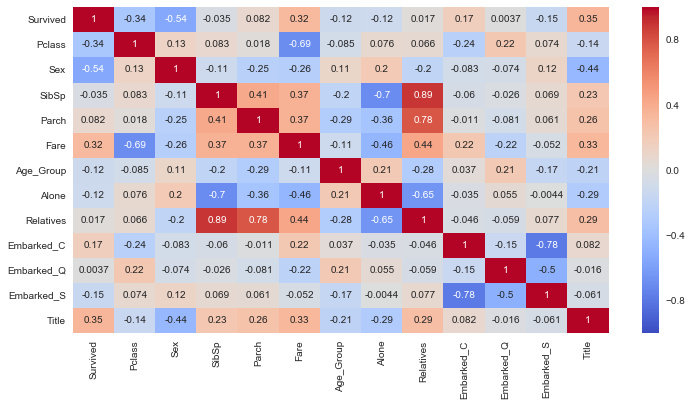

In [55]:
plt.figure(figsize=(12,6))
sns.heatmap(train.corr(),cmap='coolwarm',annot=True)

<h3>Model Training</h3>

Import the libraries required.

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import scorer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

Split the training set into features and labels and confirm the shape of the matrices.

In [57]:
X_train = train.drop('Survived', axis=1)
y_train = train['Survived']
X_test  = test
train.shape, test.shape, X_train.shape,y_train.shape, X_test.shape

((891, 13), (418, 12), (891, 12), (891,), (418, 12))

Define functions to make running models multiple times a little easier.

In [58]:
def train_model(model,name,X,y):
    """
    Takes a machine learning model from scikit-learn alongside two Data Frames containing features and labels,
    fits this training data and returns the mean accuracy of the trained model
    
    model: scikit learn model
    X_train: DataFrame of features
    y_train: DataFrame of labels
    """
    model.fit(X_train,y_train)    
    acc_model = model.score(X_train, y_train)
    print('Accuracy of {name}: {acc_model:.{digits}f}%'.format(name=name,acc_model=acc_model*100,digits=2))

In [59]:
def validation_scores(model,X,y,scoring_metrics):
    """
    Takes a machine learning model from scikit-learn alongside two DataFrames containing features and labels,
    performs cross validation and returns the mean of the scoring metric and the std for each metric within
    the scoring_metrics list.
    
    model: scikit learn model
    X_train: DataFrame of features
    y_train: DataFrame of labels
    scoring_metrics: list of scoring metrics
    """
    
    for i in range(len(scoring_metrics)):
        metric = scoring_metrics[i]
                
        score = cross_val_score(model,X=X_train,y=y_train,cv=10,scoring=metric)
        
        metric_cap = ' '.join(word[0].upper() + word[1:] for word in metric.split())
        
        print('{metric}: {mean_score:.{digits}f}% (+/- {std_score:.{digits}f}'.format(metric=metric_cap,digits=2,
                                                    mean_score= score.mean()*100,std_score = score.std()*100))
     

Lets see how well the classifiers perform out of the box

In [60]:
names = ['Logistic Regression','SVM','KNN','Random Forest']
classifiers = [LogisticRegression(),SVC(),KNeighborsClassifier(),RandomForestClassifier()]

In [61]:
df_classifiers = pd.DataFrame
for name, clf in zip(names,classifiers):
    train_model(clf,name,X_train,y_train)

Accuracy of Logistic Regression: 81.26%
Accuracy of SVM: 83.73%
Accuracy of KNN: 84.96%
Accuracy of Random Forest: 90.35%


Cross validation can then be performed to asses 

In [62]:
validation_scores(SVC(),X_train,y_train,['accuracy','precision','recall','f1'])

Accuracy: 82.04% (+/- 3.29
Precision: 79.87% (+/- 3.75
Recall: 71.32% (+/- 9.80
F1: 74.98% (+/- 5.81


The accuracy is slightly lower in the cross validation, but as the model is run on a subset of the whole dataset then this is to be expected.

There may be room to improve these results by tuning the hyperparameters of a model. For example in SVMs C, gammand the kernel are all parameters that can be altered, whichcan result in many combinations of parameters. A gridsearch takes different parameters and creates a 'grid' of all possible combinations. Scikit-learn has built in grid search functionality, where a dictionary of parameters can be passed in to create the grid.

In [63]:
param_grid = {'C': [0.1,1,10,100], 'gamma': [1,0.1,0.001], 'kernel': ['linear','rbf'],'class_weight':[None,'balanced']}

In [64]:
model = SVC()
grid = GridSearchCV(model,param_grid,refit=True,verbose=0)
grid.fit(X_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.001], 'kernel': ['linear', 'rbf'], 'class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

The best parameters from the input dictionary and the best classifier can then be found

In [65]:
grid.best_params_

{'C': 1, 'class_weight': None, 'gamma': 0.1, 'kernel': 'rbf'}

In [66]:
grid.best_estimator_

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

This best estimator can then be used as parameters for the model

In [67]:
optimised_model = grid.best_estimator_

In [68]:
train_model(optimised_model,'optimised SVM',X_train,y_train)

Accuracy of optimised SVM: 84.18%


There's a modest increase in the accuracy of the model from these new parameters, and we can perform cross validation again on the training data.

In [69]:
validation_scores(optimised_model,X_train,y_train,['accuracy','precision','recall','f1'])

Accuracy: 82.27% (+/- 3.36
Precision: 80.47% (+/- 4.42
Recall: 71.32% (+/- 9.80
F1: 75.22% (+/- 5.84


Again there's a modest increase in the cross validation scores of the model after the grid search.<br/>
Now lets try again with one of the other models, this time using Random Forest.

In [70]:
param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10, 25, 50, 70], 
              "min_samples_split" : [2, 4, 10, 12, 16, 18, 25, 35], "n_estimators": [100, 400, 700, 1000, 1500]}
grid = GridSearchCV(RandomForestClassifier(),param_grid,refit=True,verbose=0)
grid.fit(X_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'min_samples_leaf': [1, 5, 10, 25, 50, 70], 'min_samples_split': [2, 4, 10, 12, 16, 18, 25, 35], 'n_estimators': [100, 400, 700, 1000, 1500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [71]:
optimised_model  = grid.best_estimator_
train_model(optimised_model,'Random Forest',X_train,y_train)

Accuracy of Random Forest: 87.09%


The accuracy of the model has decreased with these parameters. This will be worth investigating further, potentially the off the shelf model overfit the data and this is in fact a superior model.<br/>
Lets look at the cross validation scores. Firstly for the initial model and then for the optimised model.

In [72]:
validation_scores(RandomForestClassifier(),X_train,y_train,['accuracy','precision','recall','f1'])

Accuracy: 80.48% (+/- 3.90
Precision: 77.83% (+/- 4.85
Recall: 71.35% (+/- 9.14
F1: 74.31% (+/- 7.26


In [73]:
validation_scores(optimised_model,X_train,y_train,['accuracy','precision','recall','f1'])

Accuracy: 83.06% (+/- 4.58
Precision: 82.01% (+/- 4.35
Recall: 70.79% (+/- 10.16
F1: 75.61% (+/- 7.39


Again there's a slight increase in all metrics, and with an accuracy of 82.5% I'm happy with that so let's submit!<br/>
We need to make some predictions first from the test set using our selected model.

In [74]:
y_pred = optimised_model.predict(X_test)

In [78]:
test['PassengerId'] = pd.read_csv('test.csv',usecols=['PassengerId'])

submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": y_pred
    })
#submission.to_csv('../output/submission.csv', index=False)

<h3>Future Work</h3>

I have learnt a lot from running this notebook, and it's depended my understanding of machine learning in practical aspects.<br/>
It would be good to look further into validation of model, and maybe alter the feature engineering or look at feature importance to decide on features.

Remove highly correlated variables<br/>
Run OLS and select significant features<br/>
Forward selection and backwards selection<br/>
Random Forest feature importance<br/>
Lasso

<h3>Acknoledgements</h3>

Some previous kernels that provided an excellent platform for this notebook<br/>
https://www.kaggle.com/startupsci/titanic-data-science-solutions<br/>
https://www.kaggle.com/niklasdonges/end-to-end-project-with-python<br/>
https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python<br/>
https://www.kaggle.com/ash316/eda-to-prediction-dietanic<br/>